In [0]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from torch import optim
import torchvision.models as models
import torch.nn as nn
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split


from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, BatchNormalization, Activation
from tensorflow.keras.layers import Conv2D, MaxPool2D, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam, RMSprop


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
tf.test.is_gpu_available(
    cuda_only=False, min_cuda_compute_capability=None
)

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

In [0]:
import os
## for deleting for if already exists
if os.path.exists('Train'):
  !rm -r Train
## to create Train folder to store train dataet in google collab
!mkdir Train
!tar -xzf "/content/drive/My Drive/AI Training/Ballot/Train.tar.gz" -C "Train"

In [0]:
## for deleting the train folder if already exist
if os.path.exists('Test'):
  !rm -r Test

## creating Test folder to store test dataset
!mkdir Test
!tar -xzf "/content/drive/My Drive/AI Training/Ballot/Test.tar.gz" -C "Test"

In [0]:
## train set path
train_csv_path = "Train/testset.csv"

## test set path
test_csv_path = "Test/testset.csv"

## train set images path
train_set_path = "Train/testset"

## test set images path
test_set_path = "Test/testset"

## path for saving model checkpoint in google drive
model_saving_path = "/content/drive/My Drive/AI Training/Ballot/MobileNet"

## path for saving mode_checkpoint in google collab
model_path = "model_checkpoints/"

In [7]:
## loading dataset from respective path
train_set=pd.read_csv(train_csv_path)
test_set=pd.read_csv(test_csv_path)
train_set


,Data,Label
0,600795.jpeg,10
1,627152.jpeg,10
2,119963.jpeg,10
3,118264.jpeg,10
4,199420.jpeg,10
...,...,...
9595,285044.jpeg,4
9596,383736.jpeg,4
9597,771886.jpeg,4
9598,298185.jpeg,4


In [0]:
label = train_set['Label']

In [0]:
## converting target label from integer to string
train_set['Label']=train_set['Label'].astype(str)


In [10]:
## splitting dataset into train and validation sets
train_data, val_data = train_test_split(train_set, test_size=0.1,stratify=label)
print(train_data.head())
print('val_data')
print(val_data.head())

             Data Label
6888  243859.jpeg     7
7024  147181.jpeg    38
1193  913974.jpeg    34
573   294700.jpeg     3
7411  279113.jpeg    17
val_data
             Data Label
8122  995163.jpeg    44
3064  171826.jpeg     1
4922  928515.jpeg    32
5092  322778.jpeg    21
9555  366686.jpeg     4


In [0]:
## Using ImageDataGenerator to augment the images 

datagen = ImageDataGenerator(
    preprocessing_function = lambda x : (x/127.5) - 1,
   rotation_range=10,
   width_shift_range=0.1,
   height_shift_range=0.1,
)


In [0]:
height =224
width = 224
train_batch_size =32
RANDOM_SEED = 32

In [13]:
## augmenting train dataset that is liaded from the path where images are saved
train_gen = datagen.flow_from_dataframe(
        dataframe = train_data, 
        x_col = "Data",
        y_col = "Label",
        directory = train_set_path,
        target_size=(height,width),
        class_mode="categorical",
        batch_size=train_batch_size,
        seed = RANDOM_SEED,
        shuffle=True,
        interpolation = "bilinear",
        )

train_gen

Found 8640 validated image filenames belonging to 48 classes.


In [14]:
## load anf augemnting the validation data

val_gen = datagen.flow_from_dataframe(
        dataframe = val_data, 
        x_col = "Data",
        y_col = "Label",
        directory = train_set_path,
        target_size=(height,width),
        class_mode="categorical",
        batch_size=32,
        seed = RANDOM_SEED,
        shuffle=False,
        interpolation = "bilinear",
        )

val_gen

Found 960 validated image filenames belonging to 48 classes.


In [49]:
## load and augment the test data. 
test_gen = datagen.flow_from_dataframe(
  dataframe=test_set,
  directory=test_set_path,
  x_col="Data",
  y_col=None,
  target_size=(height,width),
  seed=RANDOM_SEED,
  shuffle=False,
  class_mode=None,
  )

Found 2609 validated image filenames.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


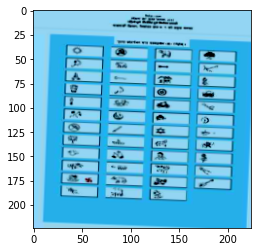

In [15]:
## observing the augmentted dataset
import matplotlib.pyplot as plt
X, y =train_gen.next()
img = np.squeeze(X[0])
plt.imshow(img)

In [34]:
## using pre-trained model MobileNet
IMG_SIZE=224
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)

base_model = tf.keras.applications.MobileNet(weights='imagenet', include_top=False)



In [0]:
## adding layers  to the base-model
x=base_model.output
x=GlobalAveragePooling2D()(x)
x=Dense(1024,activation='relu')(x) 
x=Dense(1024,activation='relu')(x) 
x=Dense(512,activation='relu')(x) 
preds=Dense(48,activation='softmax')(x) 

In [41]:
## getting final model 
model=Model(inputs=base_model.input,outputs=preds)

## getting the total layers in model
len(model.layers)

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, None, None, 3)     0         
_________________________________________________________________
conv1 (Conv2D)               (None, None, None, 32)    864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, None, None, 32)    128       
_________________________________________________________________
conv1_relu (ReLU)            (None, None, None, 32)    0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, None, None, 32)    288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, None, None, 32)    128 

92

In [42]:
## observing models layers
model.summary()

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, None, None, 3)     0         
_________________________________________________________________
conv1 (Conv2D)               (None, None, None, 32)    864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, None, None, 32)    128       
_________________________________________________________________
conv1_relu (ReLU)            (None, None, None, 32)    0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, None, None, 32)    288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, None, None, 32)    128 

In [0]:
## compling the model
model.compile(optimizer='Adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])


In [44]:
## fitting the model

train_steps = train_gen.n//train_gen.batch_size
val_steps = val_gen.n//val_gen.batch_size
history = model.fit(train_gen, steps_per_epoch=train_steps,epochs=10, validation_data=val_gen, validation_steps=val_steps)

Epoch 1/10
270/270 [==============================] - 152s 561ms/step - loss: 0.1212 - accuracy: 0.9645 - val_loss: 0.1457 - val_accuracy: 0.9542
Epoch 2/10
270/270 [==============================] - 151s 561ms/step - loss: 0.0923 - accuracy: 0.9762 - val_loss: 0.1314 - val_accuracy: 0.9510
Epoch 3/10
270/270 [==============================] - 152s 561ms/step - loss: 0.1538 - accuracy: 0.9660 - val_loss: 0.5730 - val_accuracy: 0.8385
Epoch 4/10
270/270 [==============================] - 151s 560ms/step - loss: 0.0593 - accuracy: 0.9873 - val_loss: 0.0763 - val_accuracy: 0.9865
Epoch 5/10
270/270 [==============================] - 151s 560ms/step - loss: 0.0832 - accuracy: 0.9806 - val_loss: 0.0344 - val_accuracy: 0.9927
Epoch 6/10
270/270 [==============================] - 151s 560ms/step - loss: 0.0342 - accuracy: 0.9914 - val_loss: 0.0091 - val_accuracy: 0.9969
Epoch 7/10
270/270 [==============================] - 151s 559ms/step - loss: 0.0427 - accuracy: 0.9898 - val_loss: 1.4188 -

Text(0.5, 1.0, 'Training and Validation Accuracy')

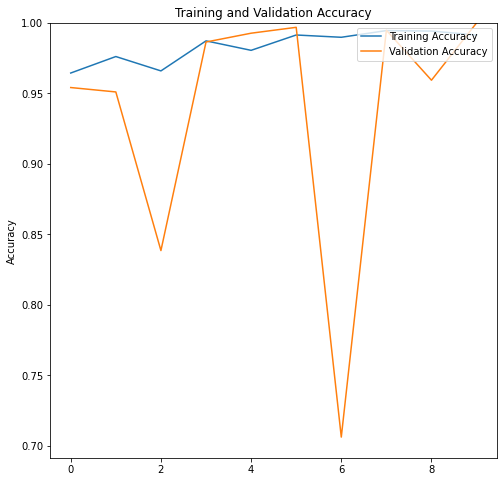

In [46]:

import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
# plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='upper right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

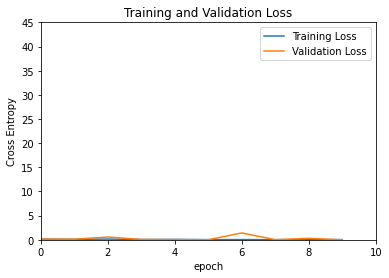

In [47]:
plt.xlim([0, 10])
plt.ylim([0, 45])
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')

plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [50]:
## get the prediction value from the test data
predictions = model.predict(test_gen)
print(predictions.shape)
predictions

(2609, 48)


array([[3.3395889e-05, 2.2872217e-15, 9.9994910e-01, ..., 2.4579122e-10,
        9.4364550e-10, 1.7150365e-05],
       [8.0955325e-04, 7.3574154e-11, 9.9857259e-01, ..., 3.1297330e-07,
        9.1702964e-07, 5.7350873e-04],
       [6.5593900e-05, 2.7102684e-14, 9.9990630e-01, ..., 1.1266819e-09,
        3.1633611e-09, 2.6568025e-05],
       ...,
       [4.6801611e-09, 5.5843611e-13, 9.9581550e-22, ..., 9.1758215e-19,
        3.8617593e-21, 4.6291791e-26],
       [2.5886878e-08, 1.1395059e-11, 1.9954331e-19, ..., 3.9198749e-17,
        3.4753577e-19, 2.8561403e-23],
       [1.0707361e-06, 1.0438712e-09, 4.3021137e-16, ..., 5.4791177e-14,
        1.7247771e-15, 5.5399687e-19]], dtype=float32)

In [51]:
## mapping the label with the indices
label_map = (train_gen.class_indices)
label_map_swapped = dict(zip(label_map.values(),label_map.keys()))
label_map_swapped

{0: '0',
 1: '1',
 2: '10',
 3: '11',
 4: '12',
 5: '13',
 6: '14',
 7: '15',
 8: '16',
 9: '17',
 10: '18',
 11: '19',
 12: '2',
 13: '20',
 14: '21',
 15: '22',
 16: '23',
 17: '24',
 18: '25',
 19: '26',
 20: '27',
 21: '28',
 22: '29',
 23: '3',
 24: '30',
 25: '31',
 26: '32',
 27: '33',
 28: '34',
 29: '35',
 30: '36',
 31: '37',
 32: '38',
 33: '39',
 34: '4',
 35: '40',
 36: '41',
 37: '42',
 38: '43',
 39: '44',
 40: '45',
 41: '46',
 42: '47',
 43: '5',
 44: '6',
 45: '7',
 46: '8',
 47: '9'}

In [52]:
## getting the predicted value
prediction_indices = tensorflow.math.argmax(predictions, 1)
prediction_indices

<tf.Tensor: shape=(2609,), dtype=int64, numpy=array([ 2,  2,  2, ..., 34, 34, 34])>

In [0]:
## getting transformed test data
X = test_gen.next()

In [59]:
## getting the predicted labels
predicted_values = []

for i in prediction_indices:
    predicted_values.append(label_map_swapped[i.numpy()])
predicted_values

['10',
 '10',
 '10',
 '10',
 '10',
 '10',
 '10',
 '10',
 '10',
 '10',
 '10',
 '10',
 '10',
 '10',
 '10',
 '10',
 '10',
 '10',
 '45',
 '45',
 '45',
 '45',
 '45',
 '45',
 '45',
 '45',
 '45',
 '45',
 '45',
 '45',
 '45',
 '45',
 '45',
 '45',
 '45',
 '45',
 '45',
 '45',
 '45',
 '45',
 '45',
 '45',
 '45',
 '45',
 '45',
 '45',
 '45',
 '45',
 '45',
 '45',
 '45',
 '45',
 '45',
 '45',
 '45',
 '45',
 '45',
 '45',
 '45',
 '45',
 '45',
 '45',
 '45',
 '45',
 '45',
 '45',
 '45',
 '45',
 '45',
 '45',
 '45',
 '45',
 '45',
 '45',
 '45',
 '45',
 '45',
 '45',
 '45',
 '45',
 '45',
 '45',
 '45',
 '45',
 '45',
 '45',
 '45',
 '45',
 '45',
 '45',
 '45',
 '45',
 '45',
 '45',
 '45',
 '45',
 '45',
 '45',
 '45',
 '45',
 '45',
 '45',
 '45',
 '45',
 '45',
 '45',
 '45',
 '45',
 '45',
 '45',
 '45',
 '45',
 '45',
 '45',
 '45',
 '45',
 '45',
 '3',
 '3',
 '3',
 '3',
 '3',
 '3',
 '3',
 '3',
 '3',
 '3',
 '3',
 '3',
 '3',
 '23',
 '23',
 '23',
 '23',
 '23',
 '23',
 '23',
 '23',
 '23',
 '23',
 '23',
 '23',
 '23',
 '23',
 '23'

In [0]:
test_set['Label'] = test_set['Label'].apply(str)


In [62]:

from sklearn.metrics import accuracy_score

acc = accuracy_score(predicted_values, test_set['Label'])
acc

0.9996167113836719

In [63]:
mobile_net = tf.saved_model.save(model, model_saving_path+'/model_checkpoint')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: /content/drive/My Drive/AI Training/Ballot/assets


In [67]:
from sklearn.metrics import classification_report, confusion_matrix

clr = classification_report(test_set['Label'], predicted_values)
print(clr)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        30
           1       1.00      1.00      1.00        33
          10       1.00      1.00      1.00        18
          11       1.00      1.00      1.00        94
          12       1.00      1.00      1.00        88
          13       1.00      1.00      1.00        92
          14       1.00      0.93      0.96        14
          15       1.00      1.00      1.00        50
          16       1.00      1.00      1.00        59
          17       1.00      1.00      1.00        14
          18       1.00      1.00      1.00        65
          19       1.00      1.00      1.00        74
           2       0.94      1.00      0.97        16
          20       1.00      1.00      1.00        86
          21       1.00      1.00      1.00        22
          22       1.00      1.00      1.00        81
          23       1.00      1.00      1.00        71
          24       1.00    

In [0]:
import csv

with open(model_saving_path+'classification_report','w',newline='') as outputFile:
  writer = csv.writer(outputFile)
  writer.writerow([clr])

Text(0.5, 1.0, 'Confusion Matrix')

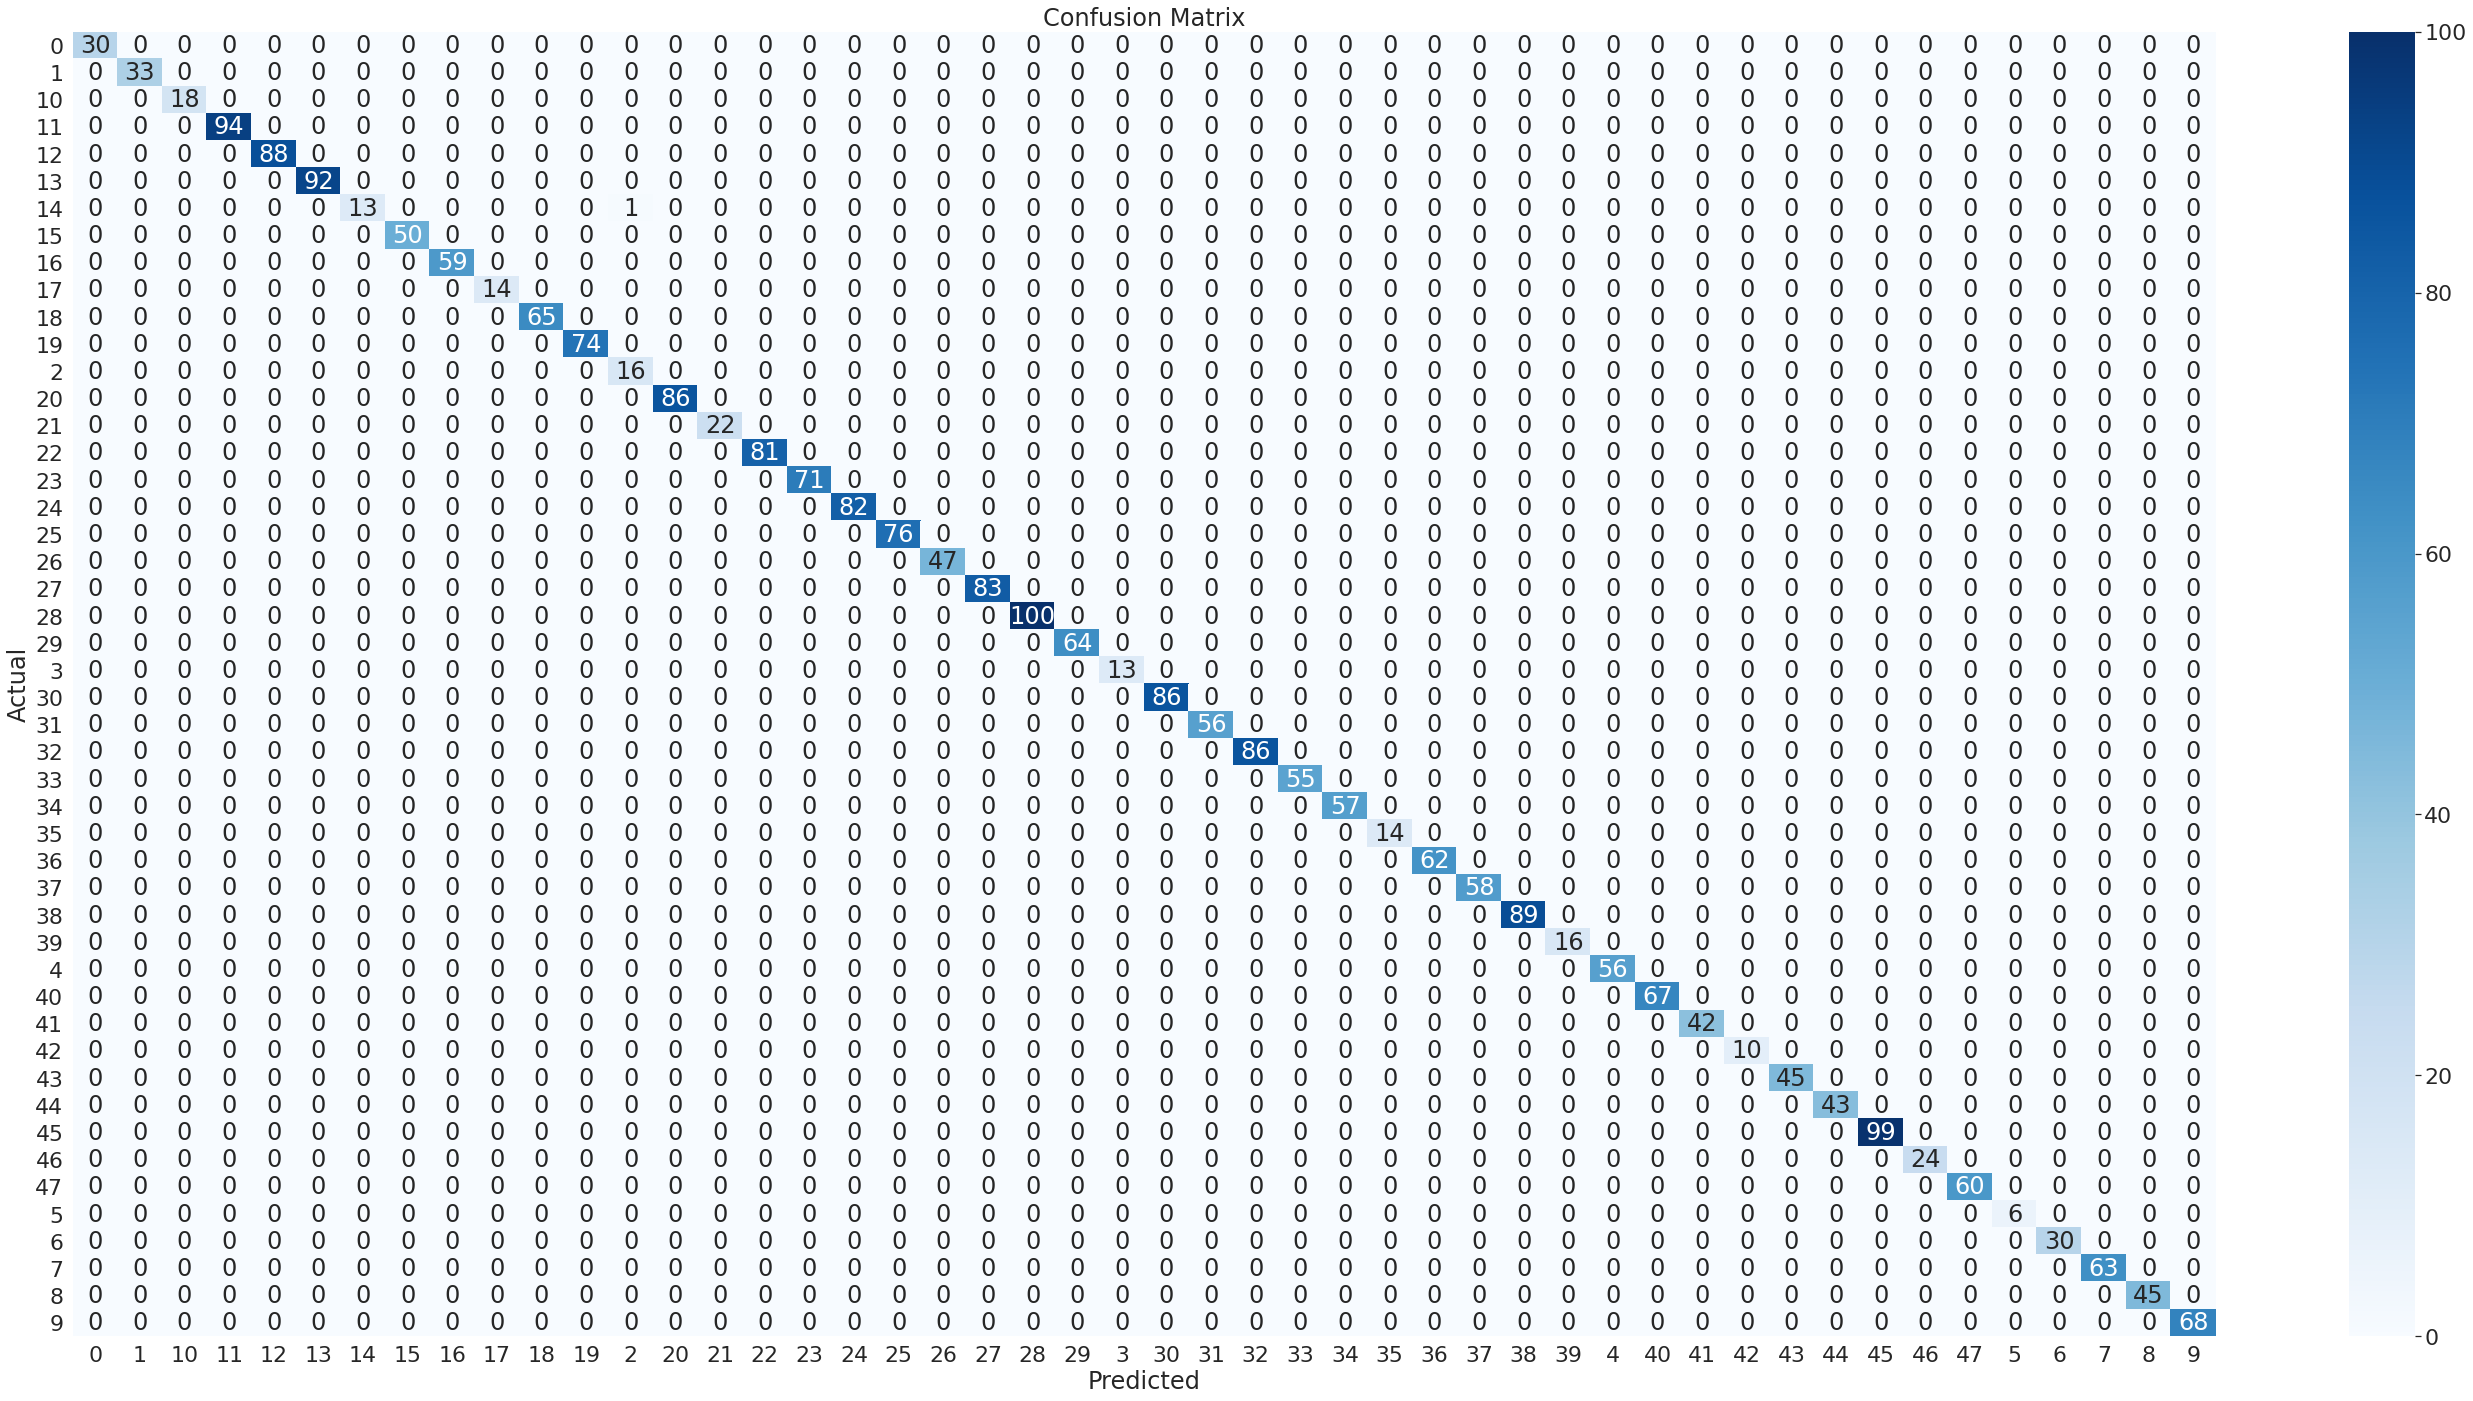

In [77]:
import seaborn as sns

cm = confusion_matrix(test_set['Label'], predicted_values)
df_cm = pd.DataFrame(cm, columns = np.unique(test_set['Label']), index = np.unique(predicted_values))
df_cm.index.name ='Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (48, 24))
ax = plt.axes()
sns.set(font_scale =2)
sns.heatmap(df_cm, cmap = "Blues", ax =ax, annot =True, fmt = "d")
ax.set_title('Confusion Matrix')


In [79]:
plt.savefig(model_saving_path+'confusion_matrix.png')

<Figure size 432x288 with 0 Axes>